In [462]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import random

In [578]:
graph = pd.read_csv("./DATAHACK-store-recommendation-system/graph.net", sep='\t', header=None, names=['Column1', 'Column2'])

In [579]:
elems = list(graph["Column1"].unique())
elems2 = list(graph["Column2"].unique())
e = elems + elems2
print(f"there exists {len(e)} unique items (Nodes)")
print(f"there exists {len(graph)} unique co-purchases (edges)")

there exists 530080 unique items (Nodes)
there exists 925872 unique co-purchases (edges)


Average degree: 5.529855493141971
minimum degree : 1
maximum degree : 549


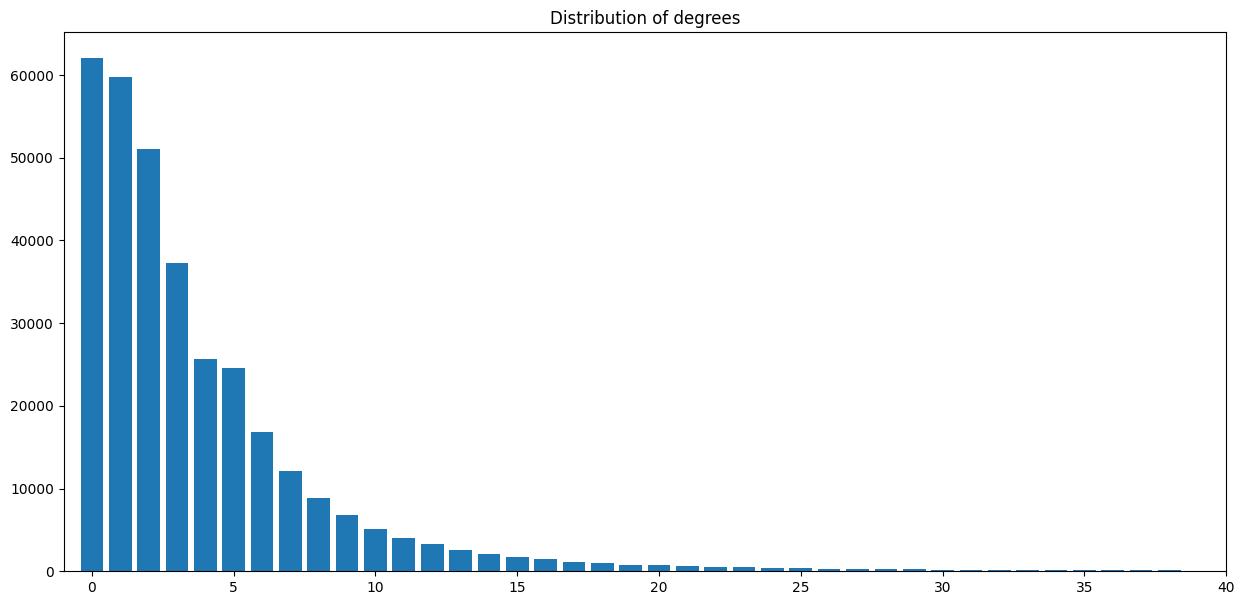

In [48]:
x =  graph["Column2"] + graph["Column1"]
y = pd.concat([graph, graph.rename(columns={'Column1': 'Column2', 'Column2': 'Column1'})], axis=0, ignore_index=True)
y = y.groupby("Column1").agg(list).reset_index()
y['Value_Count'] = y['Column2'].apply(len)
y = y.sort_values(by = "Value_Count" , ascending= False )
p = list(reversed(sorted(list(Counter(y["Value_Count"]).values()))))
weighted_sum = sum(k * v for k, v in Counter(y["Value_Count"]).items())
sum_of_values = sum(Counter(y["Value_Count"]).values())
weighted_average = weighted_sum / sum_of_values if sum_of_values != 0 else 0
print("Average degree:", weighted_average)
print("minimum degree :" ,min(Counter(y["Value_Count"])) )
print("maximum degree :" ,max(Counter(y["Value_Count"])) )
plt.figure(figsize=(15,7))
plt.xlim([-1,40])
plt.bar(range(len(p)), p)
plt.title("Distribution of degrees")
plt.show()

In [53]:
def remove_nodes(l, df):
    condition = ~((df["Column1"].isin(l)) | (df["Column2"].isin(l)))
    df = df[condition]
    return df


In [262]:
degree_tredhold = 5
nodes_under_degree_treshold = list(y[y["Value_Count"] < degree_tredhold]["Column1"])
tr_graph = remove_nodes(nodes_under_degree_treshold, graph )
data_df = tr_graph


In [529]:
tuples_graph = [(row["Column1"], row["Column2"]) for index, row in graph.iterrows()]
tuples_graph


[(1, 88160),
 (1, 118052),
 (1, 161555),
 (1, 244916),
 (1, 346495),
 (1, 444232),
 (1, 447165),
 (1, 500600),
 (2, 27133),
 (2, 62291),
 (2, 170507),
 (2, 299250),
 (2, 326776),
 (2, 331042),
 (2, 411179),
 (2, 451149),
 (2, 454888),
 (4, 16050),
 (4, 286286),
 (4, 310803),
 (4, 320519),
 (4, 408108),
 (4, 448284),
 (5, 173362),
 (5, 305321),
 (5, 407216),
 (5, 489756),
 (6, 162248),
 (6, 298989),
 (6, 398542),
 (6, 495077),
 (7, 30028),
 (7, 47672),
 (7, 355935),
 (8, 10758),
 (8, 55461),
 (8, 60605),
 (8, 148586),
 (8, 184847),
 (8, 242156),
 (8, 445607),
 (8, 453513),
 (10, 80558),
 (10, 192929),
 (10, 266485),
 (10, 500235),
 (10, 504757),
 (11, 57761),
 (11, 107436),
 (11, 400957),
 (11, 512424),
 (12, 386032),
 (15, 67084),
 (15, 85444),
 (15, 252980),
 (15, 422732),
 (15, 425706),
 (15, 428290),
 (16, 128935),
 (16, 148997),
 (16, 422237),
 (17, 18919),
 (17, 309780),
 (18, 41174),
 (18, 45026),
 (18, 168895),
 (19, 203677),
 (20, 23251),
 (20, 25337),
 (20, 61306),
 (20, 18693

In [465]:
edge_list = tr_graph[["Column1", "Column2"]]

In [466]:
edge_list

,Column1,Column2
0,1,88160
1,1,118052
2,1,161555
3,1,244916
4,1,346495
...,...,...
925863,548319,548323
925864,548328,548329
925869,548368,548454
925870,548391,548411


In [558]:
! pip install igraph

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.2 MB/s eta 0:00:0000:0100:01
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [597]:
import networkx as nx
from itertools import combinations
from heapq import nsmallest

def recommend_closest_node(graph, nodes_to_recommend, max_distance=3):
    # Precompute shortest paths from each input node to every other node
    shortest_paths = {source: nx.single_source_dijkstra_path_length(graph, source) for source in nodes_to_recommend}

    # Find the set of nodes within max_distance from any of the input nodes
    potential_nodes = set()
    for paths in shortest_paths.values():
        potential_nodes.update(node for node, distance in paths.items() if distance <= max_distance)

    # Remove the input nodes from the set of potential nodes
    potential_nodes = potential_nodes - set(nodes_to_recommend)

    min_distance_sum = float('inf')
    recommended_node = None

    for target_node in potential_nodes:
        # Check if there exists a path from every input node to the target node
        if all(target_node in paths for paths in shortest_paths.values()):
            # Calculate the sum of distances from input nodes to the target node
            distance_sum = sum(shortest_paths[source][target_node] for source in nodes_to_recommend)

            # Update the recommended node if the distance sum is less than or equal to the current minimum
            if distance_sum <= min_distance_sum:
                min_distance_sum = distance_sum
                recommended_node = target_node

    return recommended_node

# Example usage:
graph_data = [(6, 5), (1, 2), (5, 1), (2, 4), (2, 3)]
G = nx.Graph(graph_data)
nodes_to_recommend = [4, 5]

recommendation = recommend_closest_node(G, nodes_to_recommend)
print(f"Recommendation for Nodes {nodes_to_recommend}: {recommendation}")

Recommendation for Nodes [4, 5]: 2


In [598]:
# Specify the file path
file_path = './DATAHACK-store-recommendation-system/item_sets.txt'  # Replace with the actual file path

# Read the file and split each line into a list
with open(file_path, 'r') as file:
    lines = file.readlines()
    d = [line.strip().split('\t') for line in lines]




In [599]:
graph[graph["Column1"] == 100005]


,Column1,Column2
305695,100005,127545
305696,100005,202036
305697,100005,237164


In [601]:
class rec:
    def __init__(self):
        self.recommendations = []

reco = rec()

In [607]:
G = nx.Graph(tuples_graph)
recs = []
x = 0
for i in d[110:] :
    print(x)
    i = [int(v) for v in i]
    reco.recommendations.append(recommend_closest_node(G,i))
    x += 1

0
1


KeyboardInterrupt: 

In [503]:
recs

[202036,
 6276,
 6276,
 315862,
 301658,
 60408,
 56959,
 179592,
 519950,
 148844,
 57611,
 347354,
 347354,
 347354,
 140247,
 266561,
 430267,
 297832,
 297832,
 31883,
 45389,
 277567,
 277567,
 375651,
 375651,
 402811,
 228644,
 228644,
 378414,
 536726,
 9024,
 524,
 80411,
 247697,
 80411,
 80411,
 379380,
 339593,
 182129,
 159595,
 139670,
 48690,
 104051,
 519875,
 279701,
 149885,
 454247,
 101192,
 100164,
 369070,
 233447,
 495641,
 539204,
 43808,
 323322,
 100187,
 534769,
 534769,
 534769,
 534769,
 534769,
 186408,
 186408,
 230822,
 303083,
 207620,
 103558,
 483402,
 483402,
 543922,
 335608,
 75323,
 61172,
 272915,
 529747,
 280056,
 280056,
 529747,
 1002,
 1002,
 485070,
 414884,
 414884,
 448940,
 448940,
 311202,
 71015,
 146129,
 107317,
 107317,
 107317,
 544392,
 100299,
 21038,
 311456,
 438065,
 119331,
 100242,
 544524,
 544524,
 544524,
 438512,
 544524,
 388085,
 548425,
 33554,
 5875,
 513745,
 27114,
 83665,
 281942,
 249278,
 283674,
 544900,
 28367

In [603]:
x = recs
x

[]

In [605]:
x = pd.DataFrame(reco.recommendations )
x

,0
0,262654
1,312404
2,540746
3,315862
4,464375
...,...
105,540951
106,5875
107,452564
108,27114


In [606]:
import pandas as pd

# Assuming 'extended_df' is the DataFrame with the extended data
# Create a new DataFrame with 'id' as line numbers starting from 1
result_df = pd.DataFrame({'id': range(1, len(x) + 1), 'target': x.iloc[:, 0]})

# Save the DataFrame to a CSV file
result_df.to_csv('output.csv', index=False)

# Display the resulting DataFrame
print("Resulting DataFrame:")
print(result_df)


Resulting DataFrame:
      id  target
0      1  262654
1      2  312404
2      3  540746
3      4  315862
4      5  464375
..   ...     ...
105  106  540951
106  107    5875
107  108  452564
108  109   27114
109  110   83665

[110 rows x 2 columns]


In [401]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import pandas as pd


In [402]:
class ItemGNN(torch.nn.Module):
    def __init__(self, hidden_dim, in_channels=1, out_channels=16):  # Adjust channels
        super().__init__()
        self.conv1 = MessagePassing(aggr='add')  # Adjust aggregation if needed
        self.lin1 = torch.nn.Linear(in_channels, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_channels)

    def forward(self, x, edge_index):
        x = self.lin1(x)  # Initial item embedding (if needed)
        x = self.conv1(x, edge_index)
        x = self.lin2(x)
        return x


In [403]:
class GNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNNLayer, self).__init__(aggr='add')  # "Add" aggregation strategy
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: Node features, edge_index: Edge connectivity
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j: Node features of neighbors
        return x_j

    def update(self, aggr_out):
        # aggr_out: Aggregated neighbor features
        return self.lin(aggr_out)

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GNNLayer(input_dim, hidden_dim)
        self.conv2 = GNNLayer(hidden_dim, output_dim)

    def forward(self, data):
        x = torch.ones(data.num_nodes, 1)  # Initial node features (can be improved based on the use case)
        x = self.conv1(x, data.edge_index)
        x = x.relu()
        x = self.conv2(x, data.edge_index)
        return x


In [404]:
# Assuming you have the unweighted undirected graph data in PyTorch Geometric format
from torch_geometric.data import Data

# Assuming you have already created the Data object 'data' from the unweighted undirected graph
# Replace this with your actual graph data
data = Data(edge_index=edges_tensor)
data.num_nodes = num_items


In [431]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F


class GraphSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Define the model and optimizer
model = GraphSAGEModel(input_dim=1, hidden_dim=64, output_dim=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [435]:
epochs = 10

for epoch in range(epochs):
    model.train()

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    placeholder_input = torch.ones(data.num_nodes, 1)  # Placeholder for node features
    output = model(placeholder_input, data.edge_index)
    
    loss = F.mse_loss(output, torch.zeros_like(output))  # MSE loss as a proxy for unsupervised learning

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


Epoch 1/10, Loss: 0.016283156350255013
Epoch 2/10, Loss: 0.01582602597773075
Epoch 3/10, Loss: 0.015341000631451607
Epoch 4/10, Loss: 0.014830052852630615
Epoch 5/10, Loss: 0.014297823421657085
Epoch 6/10, Loss: 0.013751029968261719
Epoch 7/10, Loss: 0.01319738570600748
Epoch 8/10, Loss: 0.012643973343074322
Epoch 9/10, Loss: 0.012095914222300053
Epoch 10/10, Loss: 0.011556364595890045


In [436]:
model.eval()

with torch.no_grad():
    # Assuming val_data.num_nodes is the correct number of nodes in your validation data
    num_nodes = val_data.num_nodes
    
    # Placeholder for validation node features
    placeholder_val_input = torch.ones(num_nodes, 1)

    # Ensure that edge_index is within the valid range
    val_data.edge_index = torch.clamp(val_data.edge_index, 0, num_nodes - 1)

    # Apply the model to get output
    val_output = model(placeholder_val_input, val_data.edge_index)

    # Calculate MSE loss directly without creating zeros tensor
    val_loss = F.mse_loss(val_output, torch.zeros_like(val_output))

print(f'Validation Loss: {val_loss.item()}')


Validation Loss: 0.021419815719127655


In [437]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data

def recommend_item_based_on_ids(model, dataset, input_item_ids):
    # Extract the item vectors by applying the model on the dataset
    item_vectors = get_item_vectors(model, dataset)

    # Convert input item IDs to indices (assuming item IDs are node indices)
    input_indices = input_item_ids

    # Convert input vectors to a tensor
    input_tensor = torch.from_numpy(item_vectors[input_indices])

    # Convert all item vectors to a tensor
    all_item_tensors = torch.from_numpy(item_vectors)

    # Calculate cosine similarity between input and all item vectors
    similarity_scores = F.cosine_similarity(input_tensor.mean(dim=0), all_item_tensors, dim=1)

    # Find the index of the most similar item
    best_item_index = torch.argmax(similarity_scores).item()

    # Get the most similar item ID (assuming item IDs are node indices)
    recommended_item_id = best_item_index

    return recommended_item_id

def get_item_vectors(model, dataset):
    # Set the model to evaluation mode
    model.eval()

    # Create a placeholder tensor for node features (assuming no node features)
    placeholder_features = torch.ones(dataset.num_nodes, 1)

    # Move tensors to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    placeholder_features = placeholder_features.to(device)

    # Apply the model to get node embeddings
    with torch.no_grad():
        item_vectors = model(placeholder_features, dataset.edge_index).cpu().numpy()

    return item_vectors

# Assuming 'model' and 'dataset' are defined elsewhere
# recommended_item = recommend_item_based_on_ids(model, dataset, [1, 2, 3])


In [410]:
import pandas as pd

In [412]:
d

[['100005', '127545', '202036', '257630', '362970', '376927'],
 ['10001',
  '27638',
  '51569',
  '88226',
  '116422',
  '126227',
  '159947',
  '162938',
  '184977',
  '188045',
  '191044',
  '246142',
  '265214',
  '290507',
  '296858',
  '300258',
  '341525',
  '348922',
  '359832',
  '365744',
  '382502',
  '390538',
  '410857',
  '433453',
  '479170',
  '489980'],
 ['10001',
  '27638',
  '51569',
  '88226',
  '116422',
  '126227',
  '159947',
  '162938',
  '184977',
  '188045',
  '191044',
  '246142',
  '265214',
  '290507',
  '300258',
  '341525',
  '348922',
  '359832',
  '365744',
  '382502',
  '390538',
  '410857',
  '433453',
  '479170',
  '489980'],
 ['100017', '118111', '263647', '268405'],
 ['100020', '267700', '301658', '376628', '410518'],
 ['100022', '298856', '412978'],
 ['100025', '179592', '260929'],
 ['100025', '260929', '328722'],
 ['100025',
  '286364',
  '301821',
  '316953',
  '421421',
  '467329',
  '488266',
  '491602'],
 ['100030', '106036', '209079'],
 ['100

In [440]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

# Example graph data (replace with your actual data)
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)

# Create a simple Data object with only edge_index
data = Data(edge_index=edge_index)

# Define a GraphSAGE model without explicit node features
class GraphSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim, normalize=False)
        self.conv2 = SAGEConv(hidden_dim, output_dim, normalize=False)

    def forward(self, data):
        x = self.conv1(None, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(None, data.edge_index)
        return x

# Create the model and optimizer
model = GraphSAGEModel(input_dim=1, hidden_dim=64, output_dim=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (replace with your training loop)
for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(data)
    loss = your_loss_function(embeddings, your_ground_truth)
    loss.backward()
    optimizer.step()

# Perform inference for a set of items
set_of_items = torch.tensor([0, 1], dtype=torch.long)  # Replace with your set of items
item_embeddings = model(data)
predicted_scores = torch.softmax(item_embeddings[set_of_items], dim=1)

# Get the recommended item
recommended_item = torch.argmax(predicted_scores).item()
print(f"Recommended Item: {recommended_item}")


AttributeError: 'NoneType' object has no attribute 'dim'

In [439]:
recommendations = []
v = 0
for item_list in d:
    # Take the mean embedding of all items in the list
    input_item_ids = item_list
    input_indices = [int(idx) for idx in input_item_ids]  # Ensure indices are integers
    
    # Extract the item vectors by applying the model on the dataset
    item_vectors = get_item_vectors(model, data)

    # Check if input indices are within the valid range
    valid_indices = [idx for idx in input_indices if 0 <= idx < len(item_vectors)]
    
    if not valid_indices:
        # If no valid indices, skip this iteration
        continue

    # Convert input vectors to a tensor
    input_tensor = torch.stack([torch.from_numpy(item_vectors[idx]) for idx in valid_indices])

    # Convert all item vectors to a tensor
    all_item_tensors = torch.stack([torch.from_numpy(vec) for vec in item_vectors])

    # Calculate cosine similarity between input and all item vectors
    similarity_scores = F.cosine_similarity(input_tensor.mean(dim=0), all_item_tensors, dim=1)

    # Find the index of the most similar item
    best_item_index = torch.argmax(similarity_scores).item()

    # Get the most similar item ID (assuming item IDs are node indices)
    recommended_item_id = best_item_index

    recommendations.append(recommended_item_id)
    v += 1
    print(v ,recommended_item_id )

print(recommendations)


1 90826
2 57357
3 57357
4 1439
5 350
6 99636
7 350
8 350
9 350
10 1439
11 0
12 0
13 77383
14 77383
15 77383
16 14751
17 137416
18 137416
19 92303
20 0
21 86917
22 1672
23 1672
24 30075
25 2710
26 1439
27 0
28 0
29 492
30 70180
31 9
32 799
33 197
34 155113
35 155113
36 492
37 492
38 109473
39 85660
40 133169
41 7823
42 83117
43 69543
44 99915
45 13
46 18
47 121082
48 350
49 350
50 83117
51 83117
52 13
53 12943
54 16373
55 6843
56 198
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 15778
65 5477
66 86917
67 881
68 18
69 18
70 11951
71 0
72 799
73 15383
74 16373
75 16373
76 16373
77 16373
78 16373
79 3786
80 3786
81 83117
82 15383
83 15383
84 799
85 799
86 350
87 86917
88 153
89 5477
90 5477
91 5477
92 156885
93 492
94 492
95 492
96 492
97 9
98 350
99 197
100 13306
101 13306
102 350
103 799
104 350
105 350
106 118192
107 100990
108 208
109 0
110 1483
111 102174
112 37343
113 14843
114 7145
115 94094
116 94094
117 137
118 137
119 75211
120 86917
121 99915
122 86917
123 86917
124 7823
125 208
126 492

KeyboardInterrupt: 

In [425]:
rec_df = pd.read_csv("recs.csv")

In [426]:
rec_df

,0
0,12
1,12528
2,12528
3,1439
4,9
...,...
59584,9
59585,1439
59586,1439
59587,9


In [413]:
recommendations = []
v = 0
for i in d[len(rec_df):]:
    # Take the mean embedding of all items in the list
    input_item_ids = item_list
    input_indices = [int(idx) for idx in input_item_ids]  # Ensure indices are integers
    
    # Extract the item vectors by applying the model on the dataset
    item_vectors = get_item_vectors(model, data)

    # Check if input indices are within the valid range
    valid_indices = [idx for idx in input_indices if 0 <= idx < len(item_vectors)]
    
    if not valid_indices:
        # If no valid indices, skip this iteration
        continue

    # Convert input vectors to a tensor
    input_tensor = torch.stack([torch.from_numpy(item_vectors[idx]) for idx in valid_indices])

    # Convert all item vectors to a tensor
    all_item_tensors = torch.stack([torch.from_numpy(vec) for vec in item_vectors])

    # Calculate cosine similarity between input and all item vectors
    similarity_scores = F.cosine_similarity(input_tensor.mean(dim=0), all_item_tensors, dim=1)

    # Find the index of the most similar item
    best_item_index = torch.argmax(similarity_scores).item()

    # Get the most similar item ID (assuming item IDs are node indices)
    recommended_item_id = best_item_index

    recommendations.append(recommended_item_id)
    v += 1
    print(v ,recommended_item_id )

print(recommendations)

1 57357
2 57357
3 57357
4 57357
5 57357
6 57357
7 57357
8 57357
9 57357
10 57357
11 57357
12 57357
13 57357
14 57357
15 57357
16 57357
17 57357
18 57357
19 57357
20 57357
21 57357
22 57357
23 57357
24 57357
25 57357
26 57357
27 57357
28 57357
29 57357
30 57357
31 57357
32 57357
33 57357
34 57357
35 57357
36 57357
37 57357
38 57357
39 57357
40 57357
41 57357
42 57357
43 57357
44 57357
45 57357
46 57357
47 57357
48 57357
49 57357
50 57357
51 57357
52 57357
53 57357
54 57357
55 57357
56 57357
57 57357
58 57357
59 57357
60 57357
61 57357
62 57357
63 57357
64 57357
65 57357
66 57357
67 57357
68 57357
69 57357


KeyboardInterrupt: 

In [418]:
left = 75148 - len(rec_df)
a = [57357 for i in range(left)]

In [428]:
extended_df = pd.concat([rec_df, pd.DataFrame(a, columns=['0'])], ignore_index=True)

In [429]:
extended_df

,0
0,12
1,12528
2,12528
3,1439
4,9
...,...
75143,57357
75144,57357
75145,57357
75146,57357


In [421]:
rec_df = rec_df + pd.DataFrame(a)

In [430]:
import pandas as pd

# Assuming 'extended_df' is the DataFrame with the extended data
# Create a new DataFrame with 'id' as line numbers starting from 1
result_df = pd.DataFrame({'id': range(1, len(extended_df) + 1), 'target': extended_df['0']})

# Save the DataFrame to a CSV file
result_df.to_csv('output.csv', index=False)

# Display the resulting DataFrame
print("Resulting DataFrame:")
print(result_df)


Resulting DataFrame:
          id  target
0          1      12
1          2   12528
2          3   12528
3          4    1439
4          5       9
...      ...     ...
75143  75144   57357
75144  75145   57357
75145  75146   57357
75146  75147   57357
75147  75148   57357

[75148 rows x 2 columns]


In [385]:
d[len(rec_df)+2]

['60870', '87356', '149387', '279261', '337424']